In [251]:
import sklearn
import numpy as np
from numpy import ma
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression

In [252]:
names =['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df = pd.read_csv('train.csv',header=None,sep=",",names=names, encoding = "ISO-8859-1")

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [253]:
df['toxic_score'] = df[['toxic','severe_toxic','obscene', 'threat', 'insult', 'identity_hate']].max(axis=1)
#drop unnecessary columns
df = df.drop(['id', 'toxic','severe_toxic','obscene', 'threat', 'insult', 'identity_hate'], axis=1)
#drop first row
df.drop(df.index[:1], inplace=True)
#df.drop(df.index[:150000], inplace=True) #smaller data set

In [254]:
# print(df)

In [255]:
df.head(5)

,comment_text,toxic_score
1,Explanation\nWhy the edits made under my usern...,0
2,D'aww! He matches this background colour I'm s...,0
3,"Hey man, I'm really not trying to edit war. It...",0
4,"""\nMore\nI can't make any real suggestions on ...",0
5,"You, sir, are my hero. Any chance you remember...",0


In [256]:
bad_words = []
negative_file = open("negative-words.txt", "r")
for line in negative_file:
    bad_words.append(line.strip("\n"))
negative_file.close()
profanity_file = open("profanity-words.txt", "r")
for line in profanity_file:
    if (line.strip("\n") not in bad_words):
        bad_words.append(line.strip("\n"))
profanity_file.close()
# print(bad_words)

In [257]:
data = df.values

X = data[:,0].reshape((159571,1))
Y = data[:,1].reshape((159571,1))

toxic_count = 0
not_toxic_count = 0

X_tr = []
Y_tr = []

for index in range(0,159571):
    if (int(Y[index][0]) == 1 and toxic_count < 7500) or (int(Y[index][0]) == 0 and not_toxic_count < 7500):
        Y_tr.append(int(Y[index][0]))
        X_tr.append(X[index][0])
        if (int(Y[index][0]) == 1):
            toxic_count += 1
        else:
            not_toxic_count += 1
    if toxic_count == 7500 and not_toxic_count == 7500:
        break

# X_tr = np.array(X_tr).reshape((15000, 1))
Y_tr = np.array(Y_tr).reshape((15000, 1))

cv = sklearn.feature_extraction.text.CountVectorizer(vocabulary=bad_words)
X_tr_features = cv.fit_transform(X_tr).toarray()

print(X_tr_features)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


# Logistic Regression

In [258]:
# Scaling 
# X_tr_scale = preprocessing.scale(X_tr_features)
X_tr_scale = X_tr_features + 0.000001
# X_tr_scale = preprocessing.scale(X_tr_scale)

In [231]:
# Sigmoid function
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

In [232]:
# Append a column of ones in the beginning of x_train an save in variable a.
ones = np.ones(X_tr_scale.shape[0]).reshape((X_tr_scale.shape[0], 1))
a = np.hstack((ones, X_tr_scale))
print(a)

[[1.e+00 1.e-06 1.e-06 ... 1.e-06 1.e-06 1.e-06]
 [1.e+00 1.e-06 1.e-06 ... 1.e-06 1.e-06 1.e-06]
 [1.e+00 1.e-06 1.e-06 ... 1.e-06 1.e-06 1.e-06]
 ...
 [1.e+00 1.e-06 1.e-06 ... 1.e-06 1.e-06 1.e-06]
 [1.e+00 1.e-06 1.e-06 ... 1.e-06 1.e-06 1.e-06]
 [1.e+00 1.e-06 1.e-06 ... 1.e-06 1.e-06 1.e-06]]


In [233]:
w = np.zeros((a.shape[1], 1))
print(w.shape)

(5214, 1)


In [234]:
def hypothesis(a , w):
    return sigmoid(np.dot(a, w))

In [235]:
yhat = hypothesis(a, w)
print(yhat)

[[0.5]
 [0.5]
 [0.5]
 ...
 [0.5]
 [0.5]
 [0.5]]


In [236]:
def likelihood(X_tr , Y_tr , w , n):
    yhat = hypothesis(X_tr, w)
    Y_tr = Y_tr.reshape((yhat.shape[0], 1))
    likelihood = np.sum(Y_tr * ma.log(yhat) + (1 - Y_tr) * ma.log(1 - yhat))
    return likelihood

print(likelihood(a, Y_tr, w, a.shape[0]))

-10397.207708399179


In [237]:
# TODO - Write the gradient ascent function - 25 points
def Gradient_Ascent(a, y, learning_rate, num_iters):
    n = a.shape[0] # Number of training examples.
    # TODO - Initialize w. Zeros vector of shape x_train.shape[1],1
    w = np.zeros((a.shape[1], 1))
    # TODO - Reshape y to be a rank 2 matrix.
    y = y.reshape((y.shape[0], 1))
    # TODO - Initiating list to store values of likelihood after few iterations.
    likelihood_values = []
    for i in range(num_iters):
        yhat = hypothesis(a, w)
        error = y - yhat
        gradient = np.dot(a.T, error)
        # Updating Parameters
        w = w + (learning_rate / n) * gradient
        if (i % 100) == 0:
            print(i)
            likelihood_values.append(likelihood(a,y,w,n))
        
    return w, likelihood_values

learning_rate = 0.1
num_iters = 50000
w, likelihood_values = Gradient_Ascent(a, Y_tr, learning_rate, num_iters)
print(w)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

-5102.653630073383


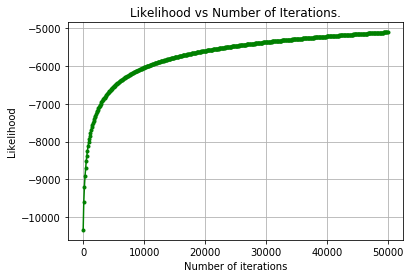

In [238]:
# Run this cell to plot Likelihood v/s Number of Iterations.
iters = np.array(range(0,num_iters,100))
plt.plot(iters,likelihood_values,'.-',color='green')
plt.xlabel('Number of iterations')
plt.ylabel('Likelihood')
plt.title("Likelihood vs Number of Iterations.")
plt.grid()
print(likelihood_values[-1])

In [259]:
logreg = LogisticRegression(C=100000000)
logreg.fit(X_tr_scale, Y_tr.ravel())
# TODO - Find the predicted values on training set using logreg.predict - 5 points
yhat = logreg.predict(X_tr_scale)
# TODO - Find the accuracy achieved on training set using logreg.score - 5 points
acc = logreg.score(X_tr_scale, Y_tr.ravel())

print("Accuracy on training data = %f" % acc)

w = logreg.coef_
intercept = logreg.intercept_
# VERIFY - Compare the parameters computed by logreg model and gradient ascent. They should be nearly same.
print(w)
print(intercept)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy on training data = 0.900133
[[-1.34643759e-06 -1.34643759e-06  1.56712564e+00 ...  5.73349422e-01
  -1.34643759e-06  7.44745727e-01]]
[-1.34643759]


# Neural Networks 

In [ ]:
names =['id', 'comment_text']
df = pd.read_csv('test.csv',header=None,sep=",",names=names, encoding = "ISO-8859-1")
df = df.drop(['id'], axis=1)
df.drop(df.index[:150000], inplace=True)

X_te = data[:,0].reshape((df.shape[0],1))
Y_te = np.zeros((df.shape[0], 1))
X_test = []
for index in range(0,df.shape[0]):
    X_test.append(X_te[index][0])
    
cv = sklearn.feature_extraction.text.CountVectorizer(vocabulary=bad_words)
X_test_features = cv.fit_transform(X_test).toarray()

X_scale = StandardScaler()
X_tr = X_scale.fit_transform(X_tr_features)
X_te = X_scale.fit_transform(X_test_features)

In [ ]:
#Setting up the output layer
def convert_y_to_vect(y):
    y_vect = np.zeros((len(y), 10))
    for i in range(len(y)):
        y_vect[i, y[i]] = 1
    return y_vect

In [ ]:
#Converting the training and test targets to vectors
y_v_train = convert_y_to_vect(y_train)
y_v_test = convert_y_to_vect(y_test)

In [ ]:
#A quick check to see that our code performs as we expect 
print(y_train[0:4])
print(y_v_train[0:4])

In [ ]:
#create neural network

In [ ]:
def f(z):
    return 1 / (1 + np.exp(-z))


def f_deriv(z):
    return f(z) * (1 - f(z))

In [ ]:
def setup_and_init_weights(nn_structure):
    W = {} #creating a dictionary i.e. a set of key: value pairs
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1])) #Return “continuous uniform” random floats in the half-open interval [0.0, 1.0). 
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

In [ ]:
def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b

In [ ]:
def feed_forward(x, W, b):
    a = {1: x} # create a dictionary for holding the a values for all levels
    z = { } # create a dictionary for holding the z values for all the layers
    for l in range(1, len(W) + 1): # for each layer
        node_in = a[l]
        z[l+1] = W[l].dot(node_in) + b[l]  # z^(l+1) = W^(l)*a^(l) + b^(l)
        a[l+1] = f(z[l+1]) # a^(l+1) = f(z^(l+1))
    return a, z

In [ ]:
def calculate_out_layer_delta(y, a_out, z_out):
    # delta^(nl) = -(y_i - a_i^(nl)) * f'(z_i^(nl))
    return -(y-a_out) * f_deriv(z_out) 


def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)

In [ ]:
#The Back Propagation Algorithm
def train_nn(nn_structure, X, y, iter_num=3000, alpha=0.25):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    N = len(y)
    avg_cost_func = []
    print('Starting gradient descent for {} iterations'.format(iter_num))
    while cnt < iter_num:
        if cnt%1000 == 0:
            print('Iteration {} of {}'.format(cnt, iter_num))
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0
        for i in range(N):
            delta = {}
            # perform the feed forward pass and return the stored a and z values, to be used in the
            # gradient descent step
            a, z = feed_forward(X[i, :], W, b)
            # loop from nl-1 to 1 backpropagating the errors
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i,:], a[l], z[l])
                    avg_cost += np.linalg.norm((y[i,:]-a[l]))
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(a^(l))
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(a[l][:,np.newaxis]))# np.newaxis increase the number of dimensions
                    # trib^(l) = trib^(l) + delta^(l+1)
                    tri_b[l] += delta[l+1]
        # perform the gradient descent step for the weights in each layer
        for l in range(len(nn_structure) - 1, 0, -1):
            W[l] += -alpha * (1.0/N * tri_W[l])
            b[l] += -alpha * (1.0/N * tri_b[l])
        # complete the average cost calculation
        avg_cost = 1.0/N * avg_cost
        avg_cost_func.append(avg_cost)
        cnt += 1
    return W, b, avg_cost_func


def predict_y(W, b, X, n_layers):
    N = X.shape[0]
    y = np.zeros((N,))
    for i in range(N):
        a, z = feed_forward(X[i, :], W, b)
        y[i] = np.argmax(a[n_layers])
    return y

In [ ]:
#run n

In [ ]:
nn_structure = [64, 30, 10]
    
# train the NN
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000)